In [11]:
!pip install einops
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from hdst import HDST
import torch
import gc
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Args Configuration Class

In [12]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 128
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 20
    # window_size: int = 10
    window_size: str = "Auto"

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [13]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0.25,
        'global_vatiant_contrast': 0.25,
        'dynamic_trend_pred': 0.5,
    },
    eval=False,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

## Load your data
You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.
Choosing from "UCR", "UEA", "ECG" and "HAR" (ECG and HAR are not available right now)

### UCR
There are 128 UCR Time Series Classification datasets under UCR folder. Choose one to load.

In [14]:
# train_data, train_labels, test_data, test_labels = datautils.load_UCR("ACSF1")
# print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

### UEA
There are 30 multivariate UEA Time Series Classification datasets under UEA folder. Choose one to load.

In [15]:
train_data, train_labels, test_data, test_labels = datautils.load_UEA("AtrialFibrillation")
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

Shapes - train data: (15, 640, 2), test data: (15, 640, 2)


## Create and Train the model

In [16]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

3733

In [17]:
import time
start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (15, 640, 2)
Scale list: [49, 16, 30]


Training: 100%|██████████| 200/200 [01:10<00:00,  2.84it/s, epoch=200, loss=0.94] 

Model training time: 70.56 seconds


Save model and loss log

In [18]:
import torch
torch.save(model, 'mymodel.pth')
import pandas as pd
df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
df.to_csv("loss_log.csv", index=False)

Visualize the loss curve and save figure

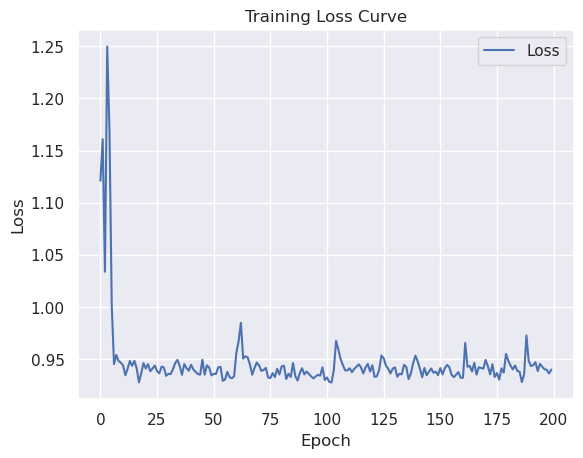

In [19]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a simple classifier (svm) using training representation and corresponding training labels. Finally, use the classifier to do calssification for test representation. Report the acc and auprc.

In [20]:
from tasks import _eval_protocols as eval_protocols
train_repr = model.encode(train_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
test_repr = model.encode(test_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
print(type(train_repr))
print(test_repr.shape)
fit_clf = eval_protocols.fit_svm
clf = fit_clf(train_repr, train_labels)
acc = clf.score(test_repr, test_labels)
y_score = clf.decision_function(test_repr)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
test_labels_onehot = label_binarize(test_labels, classes=np.arange(train_labels.max()+1))
auprc = average_precision_score(test_labels_onehot, y_score)
print( 'acc:', acc, 'auprc:', auprc )

<class 'numpy.ndarray'>
(15, 256)
acc: 0.26666666666666666 auprc: 0.4114285714285715


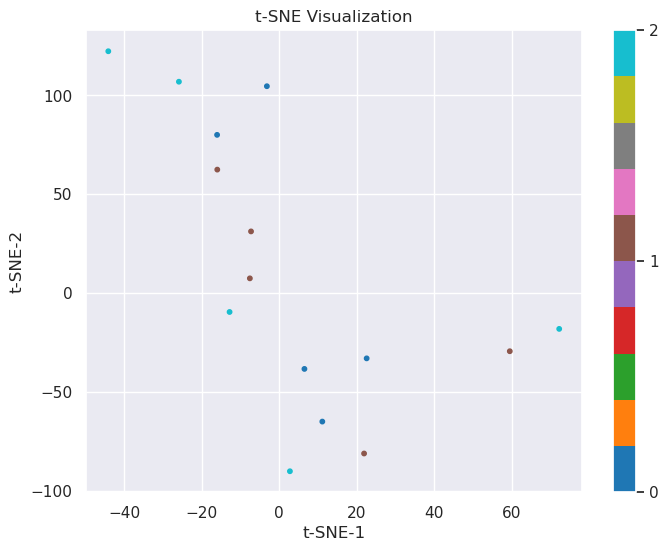

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Your data
# train_repr: shape (n_samples, n_features)
# train_labels: shape (n_samples,)
# Encode labels to integers (if not already)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_labels)

n_samples = train_repr.shape[0]
perplexity = min(30, (n_samples - 1) // 3)  # Safe heuristic

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca', random_state=42)
embedded = tsne.fit_transform(train_repr)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedded[:, 0], embedded[:, 1], c=labels_encoded, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=np.unique(labels_encoded))
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()


In [22]:
print(train_labels)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
